## INTRODUCTION

L'objectif de ce projet est d'implémenter un schéma fromm et de comparer les résultats obtenus par ce schéma aux résultats obtenus par le Godunov d'ordre 1 déjà implémenté. Dans un premier temps, nous allons rapidement présenter le schéma fromm et d'où il vient/ sur quels principes il s'appuit. Dans un deuxième temps, nous nous concentrerons sur l'implémentation du code. Et enfin en dernier nous commenterons et analyserons les résultats obtenus et nous discuterons de ce qu'ils représentent.

## 1 - Partie théorique

Le but de cette partie est de présenter rapidement le schéma fromm. Le schéma fromm est un schéma numérique utilisé pour résoudre des équations aux dérivées partielles, en particulier pour les problèmes de transport et d'advection dans des flux de fluides. Il appartient aux méthodes de différences finies et se situe entre les schémas centrés et décentrés, car il combine les approches amont et aval pour minimiser la dissipation et la dispersion numérique. Dans notre cas, on va coder un schéma de Lax Wendroff et un schéma Beam Warming et faire la moyenne des deux flux obtenus, ce qui nous donnera donc un schéma fromm.

Le Lax Wendroff est un schéma de second ordre en temps et en espace pour résoudre des équations d'évolution hyperboliques. Il est conçu pour être non dissipatif, ce qui le rend adapté pour des problèmes de propagation d'ondes sans perte de signal. Il utilise une expansion de Taylor en temps ce qui garantit un ordre élevé de précision en temps. C'est un schéma centré qui est définit comme :

\begin{equation}
    F_{j+1/2}^n = 0.5 \times (f(w_{j+1}^n) + f(w_{j}^n)) - \frac{A^2\nu}{2}[w_{j+1}^n - w_{j}^n]
\end{equation}

Le Beam Warming est un schéma de type différences finies utilisée pour résoudre les équations hyperboliques. Il s'agit d'un schéma de deuxième ordre en espace et en temps, ce qui le rend plus précis que les schémas de premier ordre pour les simulations nécessitant une bonne résolution des variations spatiales et temporelles de la solution. C'est un schéma décentré à gauche définit comme :

\begin{equation}
    F_{j+1/2}^n = 0.5 \times (3f(w_{j}^n) + f(w_{j-1}^n)) - \frac{A^2\nu}{2}[w_{j}^n - w_{j-1}^n]
\end{equation}

## 2 - Le code

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import test_suite2 as ts
import misc as mi
epsilon = 1e-6
import GodunovFirstOrderUpwindScheme1 as godunov
import test_bis2 as tsb

In [35]:
#Définition de la classe Fromm : Schema fromm
class Fromm():
#Récupération des paramètres d'initialisation
    def __init__(self, testCase):
        self.dx = testCase.dx
        self.dt = testCase.dt
        self.tFinal = testCase.tFinal
        self.nu = testCase.nu
        self.u0 = testCase.u0
        self.flux = testCase.flux
        self.u_star = testCase.u_star
        self.a = testCase.a
        self.x = testCase.x
        self.uFinal = testCase.uFinal
        
#Code du Beam Warming : Flux au pas j (FLux0) et au pas j+1(Flux1)
    def fillFlux0_Beam(self, w, f, a):
        N = w.shape[0] #Dimension de w pour permettre la création de tableaux de la même dimension
        a_ = np.empty(N) #Création du tableau de la matrice A 
        #Boucle de remplissage de la matrice A avec la formule A = 1/2(a(w[j-1]) +a(w[j-2])) avec a la vitesse de phase
        for j in range(2, N-2):
            a_[j] = 0.5*(a(w[j-1])+a(w[j-2]))
        flux = np.empty(N) #Création d'un tableau vide pour stocker les valeurs de flux
        flux[2:-2] = 0.5 *(3*f(w[1:-3])-f(w[0:-4]))  - 0.5 * a_[2:-2]*a_[2:-2]*self.nu *(w[1:-3] -  w[0:-4]) #Remplissage du tableau de flux avec la formule Beam
        flux = mi.fillGhosts(flux,num_of_ghosts=2)
        return flux

#Même procédé que pour le Flux au temps j mais au temps j+1 = Flux1
    def fillFlux1_Beam(self, w, f, a):
        N = w.shape[0]
        a_ = np.empty(N)
        for j in range(2, N-2):
            a_[j] = 0.5*(a(w[j])+a(w[j-1]))
        flux = np.empty(N)
        flux[2:-2] = 0.5 *(3*f(w[2:-2])-f(w[1:-3]))  - 0.5 * a_[2:-2]*a_[2:-2]*self.nu *( w[2:-2] -  w[1:-3])
        flux = mi.fillGhosts(flux,num_of_ghosts=2)
        return flux

#Code du Lax Wendroff : Flux au pas j (FLux0) et au pas j+1(Flux1)
    def fillFlux0_Lax(self, w, f, a):
        N=w.shape[0]
        a_=np.empty(N)
        for i in range(1,N-1):
            a_[i]=a(w[i])
        flux=np.empty(N)
        flux[1:-1]=0.5 *(f(w[1:-1])+f(w[0:-2]))  - 0.5 * a_[1:-1]*a_[1:-1]*self.nu *(w[1:-1] -  w[0:-2])
        flux=mi.fillGhosts(flux)
        return flux
 
    def fillFlux1_Lax(self, w, f, a):
        N=w.shape[0]
        a_=np.empty(N)
        for i in range(1,N-1):
            a_[i]=a(w[i+1])
        flux=np.empty(N)
        flux[1:-1]=0.5 *(f(w[2:])+f(w[1:-1]))  - 0.5 * a_[1:-1]*a_[1:-1]*self.nu *(w[2:] -  w[1:-1])
        flux=mi.fillGhosts(flux)
        
        return flux
#Définition de la fonction compute
    def compute(self, tFinal):
        Nt = int(tFinal/self.dt) #Nombre de pas de temps final
        dx = self.dx #Pas d'espace

        u0w = mi.addGhosts(self.u0(self.x),num_of_ghosts=2) #Initialisation de u = u0
        u0w = mi.fillGhosts(u0w,num_of_ghosts=2) #Remplissage periodique des cases fantômes

        xw = mi.addGhosts(self.x,num_of_ghosts=2) #Ajustement de x à la dimension de w
        
        xw[1]=xw[2]-dx
        xw[0] = xw[1]-dx
        xw[-2]= xw[-3]+dx
        xw[-1] = xw[-2]+dx
        
        #Création de tableaux vides pour u au temps n+1 et le flux au pas j et j+1
        u1w = np.empty((u0w.shape[0])) 
        F0w = np.empty((u0w.shape[0]))
        F1w = np.empty((u0w.shape[0]))

        for i in range(Nt):
            #Code du fromm = 0.5(Flux(Lax) + Flux(Beam))
            F0w = 0.5*(self.fillFlux0_Beam(u0w, self.flux, self.a) + self.fillFlux0_Lax(u0w, self.flux, self.a)) 
            F1w = 0.5*(self.fillFlux1_Beam(u0w, self.flux, self.a) + self.fillFlux1_Lax(u0w, self.flux, self.a))
            F1w = mi.fillGhosts(F1w,num_of_ghosts=2)

            u1w[2:-2] = u0w[2:-2] - self.nu * (F1w[2:-2] - F0w[2:-2]) #Détermination de u1 au pas n+1 en prenant en compte l'équation dtu + dxf = 0 et en discrétisant
            u1w = mi.fillGhosts(u1w,num_of_ghosts=2) #Remplissage des cases fantomes par des conditions périodiques
            u0w = u1w

        self.uF = u1w[2:-2]


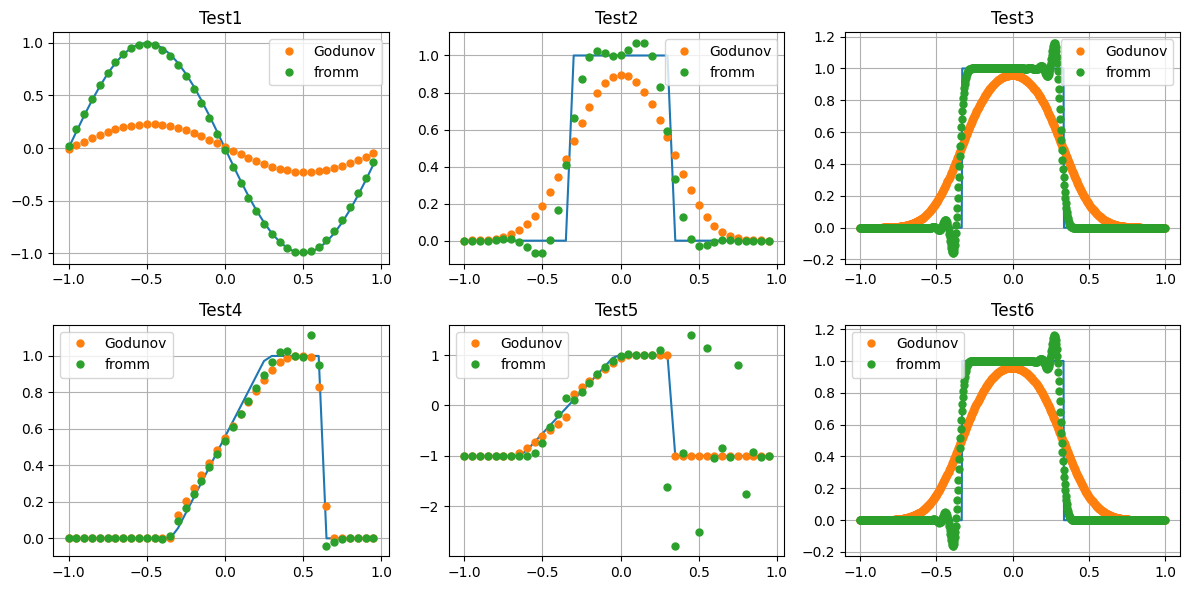

In [36]:
#Vérification des tests : comparaison fromm Godunov
#Test 1
tst = ts.Test1()
scheme = Fromm(tst)
schemegov = godunov.Godunov1(tst, form='vanilla')
scheme.compute(scheme.tFinal)
schemegov.compute(schemegov.tFinal)

#Test2
tst2 = ts.Test2()
scheme2 = Fromm(tst2)
schemegov2 = godunov.Godunov1(tst2, form='vanilla')
scheme2.compute(scheme2.tFinal)
schemegov2.compute(schemegov2.tFinal)

#Test3
tst3 = ts.Test3()
scheme3 = Fromm(tst3)
schemegov3 = godunov.Godunov1(tst3, form='vanilla')
scheme3.compute(scheme3.tFinal)
schemegov3.compute(schemegov3.tFinal)

#Test4
tst4 = ts.Test4()
scheme4 = Fromm(tst4)
schemegov4 = godunov.Godunov1(tst4, form='vanilla')
scheme4.compute(scheme4.tFinal)
schemegov4.compute(schemegov4.tFinal)

#Test5
tst5 = ts.Test5()
scheme5 = Fromm(tst5)
schemegov5 = godunov.Godunov1(tst5, form='vanilla')
scheme5.compute(scheme5.tFinal)
schemegov5.compute(schemegov5.tFinal)

#Test6 
tst6 = tsb.Test6()
scheme6 = Fromm(tst6)
schemegov6 = godunov.Godunov1(tst6, form='vanilla')
scheme6.compute(scheme6.tFinal)
schemegov6.compute(schemegov6.tFinal)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs[0, 0].plot(scheme.x, scheme.uFinal)
axs[0, 0].plot(schemegov.x, schemegov.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[0, 0].plot(scheme.x, scheme.uF, marker = "o", markersize=5, linestyle = "None",label = "fromm")
axs[0, 0].legend(loc="upper right")
axs[0, 0].grid(True)
axs[0, 0].set_title("Test1")

axs[0, 1].plot(scheme2.x, scheme2.uFinal)
axs[0, 1].plot(schemegov2.x, schemegov2.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[0, 1].plot(scheme2.x, scheme2.uF, marker = "o", markersize=5, linestyle = "None",label = "fromm")
axs[0, 1].legend(loc="upper right")
axs[0, 1].grid(True)
axs[0, 1].set_title("Test2")

axs[0, 2].plot(scheme3.x, scheme3.uFinal)
axs[0, 2].plot(schemegov3.x, schemegov3.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[0, 2].plot(scheme3.x, scheme3.uF, marker = "o", markersize=5, linestyle = "None",label="fromm")
axs[0, 2].legend(loc="upper right")
axs[0, 2].grid(True)
axs[0, 2].set_title("Test3")

axs[1, 0].plot(scheme4.x, scheme4.uFinal)
axs[1, 0].plot(schemegov4.x, schemegov4.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[1, 0].plot(scheme4.x, scheme4.uF, marker = "o", markersize=5, linestyle = "None",label = "fromm")
axs[1, 0].legend(loc="upper left")
axs[1, 0].grid(True)
axs[1, 0].set_title("Test4")

axs[1, 1].plot(scheme5.x, scheme5.uFinal)
axs[1, 1].plot(schemegov5.x, schemegov5.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[1, 1].plot(scheme5.x, scheme5.uF, marker = "o", markersize=5, linestyle = "None",label = "fromm")
axs[1, 1].legend(loc="upper left")
axs[1, 1].grid(True)
axs[1, 1].set_title("Test5")

axs[1, 2].plot(scheme6.x, scheme6.uFinal)
axs[1, 2].plot(schemegov6.x, schemegov6.uF, marker = "o", markersize=5, linestyle = "None",label ="Godunov")
axs[1, 2].plot(scheme6.x, scheme6.uF, marker = "o", markersize=5, linestyle = "None",label = "fromm")
axs[1, 2].legend(loc="upper left")
axs[1, 2].grid(True)
axs[1, 2].set_title("Test6")

plt.tight_layout()
plt.show()

- Analyser les discontinuités : Les instabilités à gauche = Beam Warming décentré à gauche => entraîne des discontinuités à gauche. Ordre 2 donc gère mal les discontinuités => Cours de smets
- Raréfaction pour le test 5 => On a un endroit vers 0 où il n'y a aucun pts de calculés.